In [50]:
from compare import RESULTS_FILE_NAME, INPUT_FILE_NAME, ALGORITHMS, LABELS, LABELS_COMPRESSIONS, FIG_DIR, KS, ALG_OLD, ALG_MATCHTIGS, load_all_inputs, load_all_results
from compare_penalties import RESULTS_FILE_NAME as PENALTY_RESULTS_FILE_NAME

import matplotlib.pyplot as plt
import seaborn as sns
import math

LABELS_READABLE = ["Length of superstring", "Number of runs of ones", "Time [seconds]", "Memory [kB]", "Objective", "Relative objective"]

plt.rcParams["font.family"] = "serif"

In [51]:
results = load_all_results("../" + RESULTS_FILE_NAME)
print(list(results)[0])
print(len(results))

penalty_results = load_all_results("../" + PENALTY_RESULTS_FILE_NAME)
print(list(penalty_results)[0])
print(len(penalty_results))

inputs = list(map(lambda x: tuple(x.split()), load_all_inputs("../" + INPUT_FILE_NAME)))
print(*inputs, sep="\n")

('counting', 'ecoli_pangenome_661k_HQ.unitigs_k128.fa', 23, True, None)
186
('loac', 'spneumoniae.fa', 31, False, 1)
1186
('sars_cov_2.fna', '128', '16', '-', '0')
('spneumoniae.fa', '128', '13', '-', '0')
('ecoli.fna', '128', '16', '-', '0')
('scerevisiae.fna', '128', '13', 'S._cerevisiae', '0')
('athaliana.fna', '128', '12', 'A._thaliana', '0')
('celegans.fa', '96', '12', 'C._elegans', '0')
('dmelanogaster.fna', '96', '12', 'D._melanogaster', '0')
('ngono_pangenome_RASE_db.unitigs_k128.fa', '128', '7', 'N._gonorrheae_(p)', '0')
('spneumo_pangenome_RASE_db.unitigs_k128.fa', '128', '7', 'S._pneumoniae_(p)', '0')
('sars-cov-2_pangenome_gisaid.unitigs_k128.fa', '128', '8', 'Sars-cov-2_(p)', '0')
('human_microbiome_illumina_srs063932.unitigs_minfreq2_k32.fa', '32', '7', 'Human_microbiome_(p)', '0')
('ecoli_pangenome_661k_HQ.unitigs_k128.fa', '32', '7', 'E._coli_(p)', '0')


In [52]:
def print_fixed_k_run_penalties(inp, ks, save=False):
    LABELS_SUBSET = [LABELS[0], LABELS[1], LABELS[4]]
    LABELS_READABLE_SUBSET = [LABELS_READABLE[0], LABELS_READABLE[1], LABELS_READABLE[4]]
    RUN_PENALTIES = list(range(max(ks) + 1 + 1))

    # print(inp)
    name = inp[3].replace("(p)", "pangenome").replace("_", " ").strip()
    if name == "-": return
    inp = inp[0]
    if "subsampled" in inp: return
    empty = True
    
    fig, axs = plt.subplots(2, 3)
    fig.set_figheight(9)
    fig.set_figwidth(13.5)
    fig.tight_layout(w_pad=2.5, h_pad=3.5, rect=(0, 0, 0.97, 1))
    
    best_penalty = dict()
    complements = True
    for k in ks:
        for alg in ALGORITHMS[:2]:
            ys = [list() for label in LABELS_SUBSET]
            rels = [list() for label in LABELS_SUBSET]
            best_penalty[k] = (0, 0)
            for run_penalty in range(max(ks) + 1):
                if (alg == ALG_OLD): run_penalty = None
                if not (alg, inp, k, complements, run_penalty) in penalty_results.keys(): continue
                empty = False

                d = penalty_results[(alg, inp, k, complements, run_penalty)]
                for i in range(len(LABELS_SUBSET)):
                    ys[i].append(d[LABELS_SUBSET[i]])
                    if alg != ALG_OLD and i == len(LABELS_SUBSET) - 1:
                        rels[i].append(ys[i][-1] / penalty_results[(ALG_OLD, inp, k, complements, None)][LABELS_SUBSET[i]])

                if (d[LABELS_SUBSET[2]] < best_penalty[k][1] or best_penalty[k][1] == 0):
                    best_penalty[k] = (run_penalty, d[LABELS_SUBSET[2]])

            for i, label in enumerate(LABELS_SUBSET):
                if alg != ALG_OLD and i == len(LABELS_SUBSET) - 1:
                    ax2 = axs[(0 if k == 23 else 1), i % 3].twinx()
                    sns.lineplot(y=rels[i] + [1], x=RUN_PENALTIES[:len(ys[0]) + 1], ax=ax2, marker=None, markeredgewidth=0, alpha=0)

                sns.lineplot(y=ys[i], x=RUN_PENALTIES[:len(ys[0])], ax=axs[(0 if k == 23 else 1), i % 3],
                                marker=None if alg == ALG_OLD else ("o" if complements else "s"),
                                markeredgewidth=0, label=("k = " + str(k) + " " + ("GGMO" if alg == ALG_OLD else "LOAC"))) #+ ("(c)" if complements else ""))

    # fig.suptitle(f"{name}, k = {k}, best run penalty = {best_penalty[k][0]}")
    for k in ks:
        print(f"{name}, k = {k}, best run penalty = {best_penalty[k][0]}")

    if empty: fig.clf()
    
    for i, label in enumerate(LABELS_READABLE_SUBSET):
        for j in range(2):
            ax = axs[j, i % 3]
            ax.set_title(label)
            ax.set(xticks=RUN_PENALTIES[::5])
            ax.set_xlabel("Run penalty")
            if i == 1: ax.set_ylim(bottom=0)
    
    if save and not empty: fig.savefig(f"../{FIG_DIR}/{name}-run-penalty.pdf")


S. cerevisiae, k = 23, best run penalty = 12
S. cerevisiae, k = 31, best run penalty = 13
A. thaliana, k = 23, best run penalty = 11
A. thaliana, k = 31, best run penalty = 12
C. elegans, k = 23, best run penalty = 11
C. elegans, k = 31, best run penalty = 12
D. melanogaster, k = 23, best run penalty = 11
D. melanogaster, k = 31, best run penalty = 12
N. gonorrheae pangenome, k = 23, best run penalty = 7
N. gonorrheae pangenome, k = 31, best run penalty = 7
S. pneumoniae pangenome, k = 23, best run penalty = 7
S. pneumoniae pangenome, k = 31, best run penalty = 7
Sars-cov-2 pangenome, k = 23, best run penalty = 8
Sars-cov-2 pangenome, k = 31, best run penalty = 8
Human microbiome pangenome, k = 23, best run penalty = 7
Human microbiome pangenome, k = 31, best run penalty = 7
E. coli pangenome, k = 23, best run penalty = 7
E. coli pangenome, k = 31, best run penalty = 7


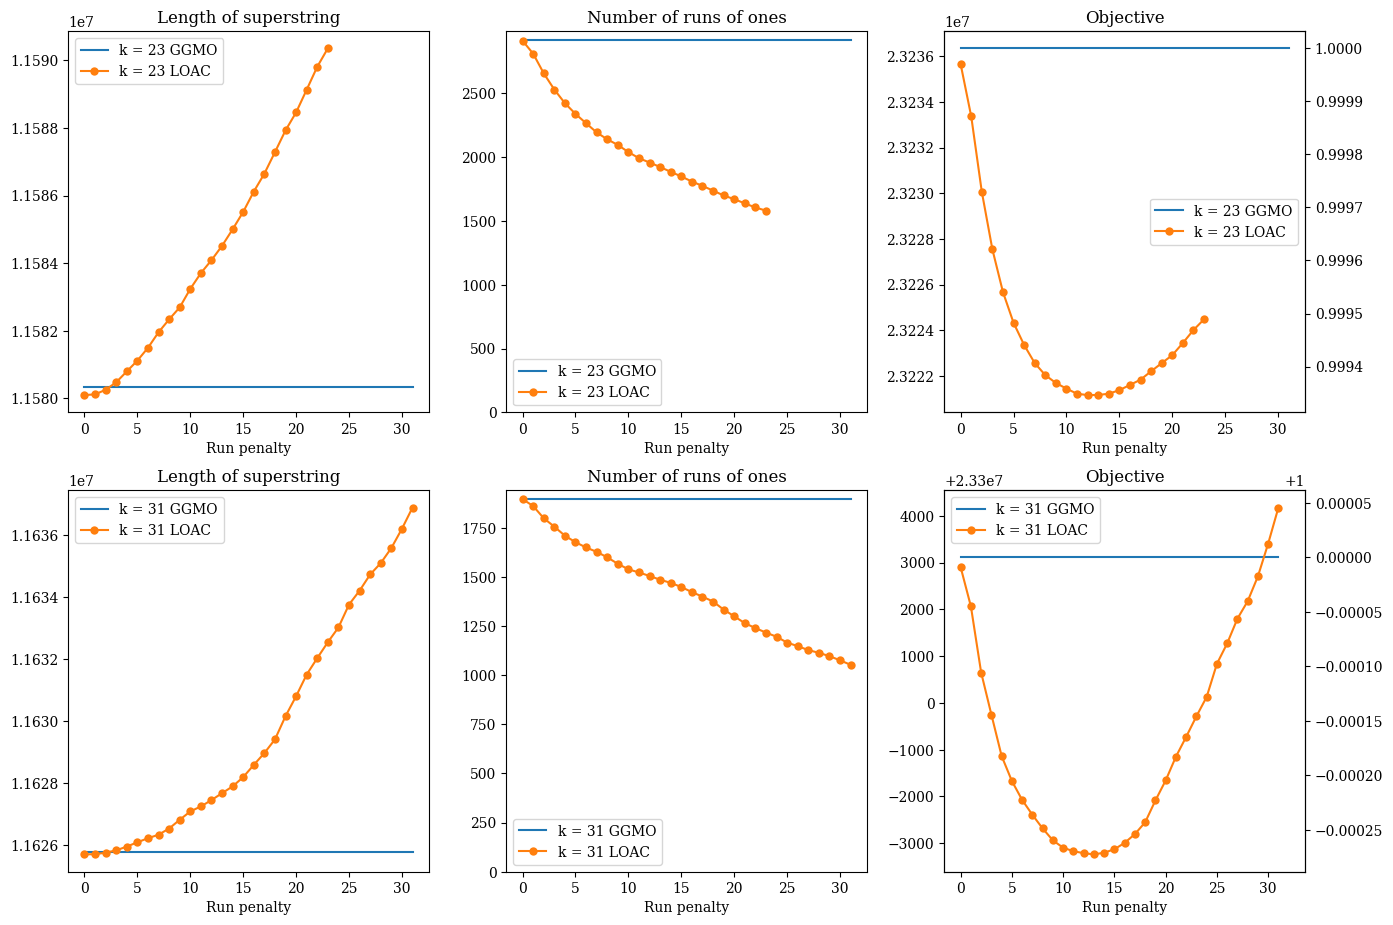

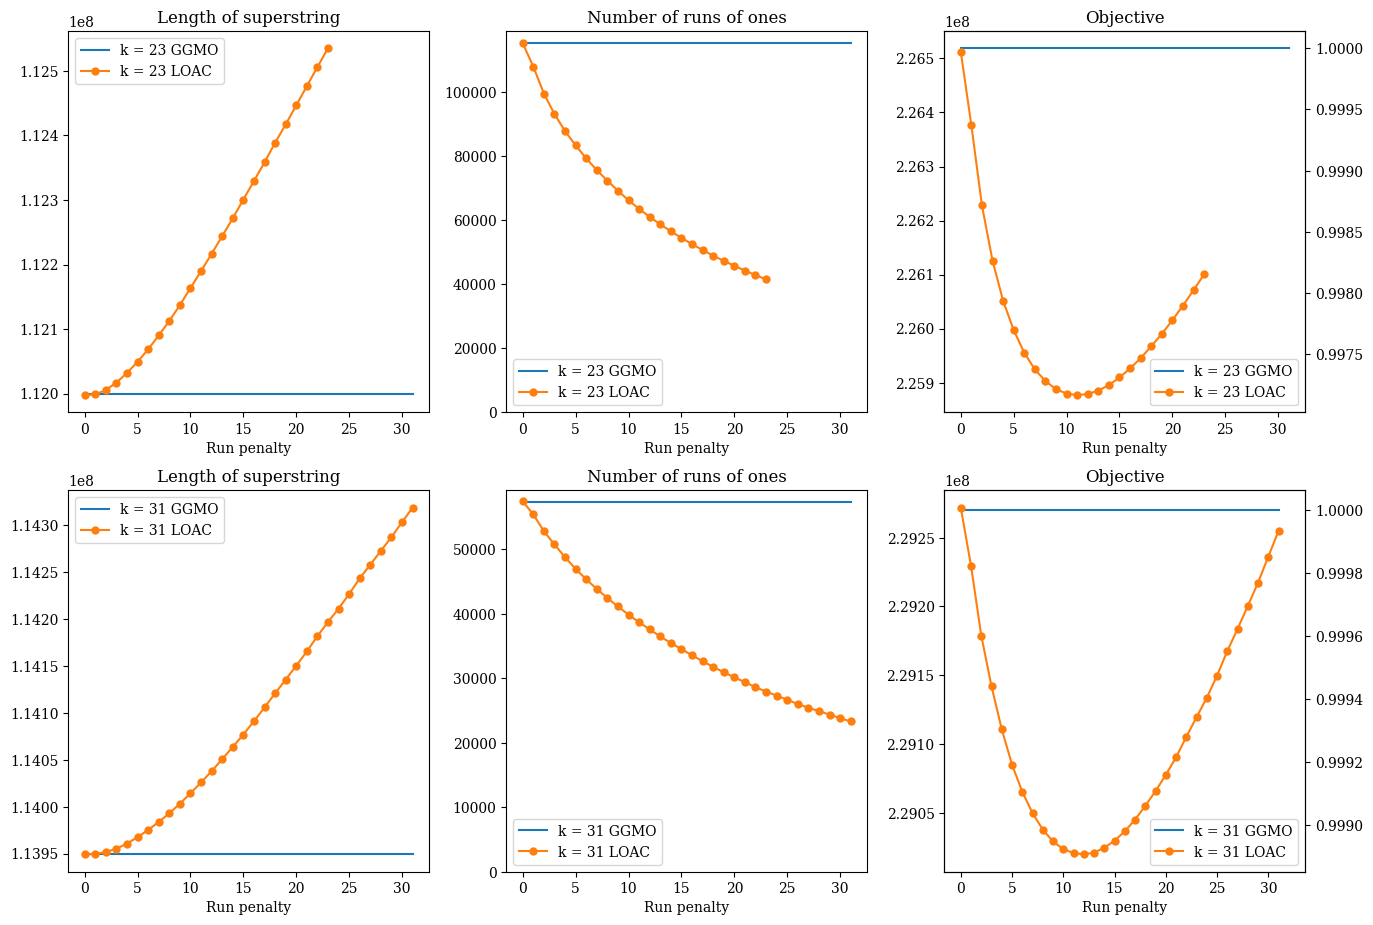

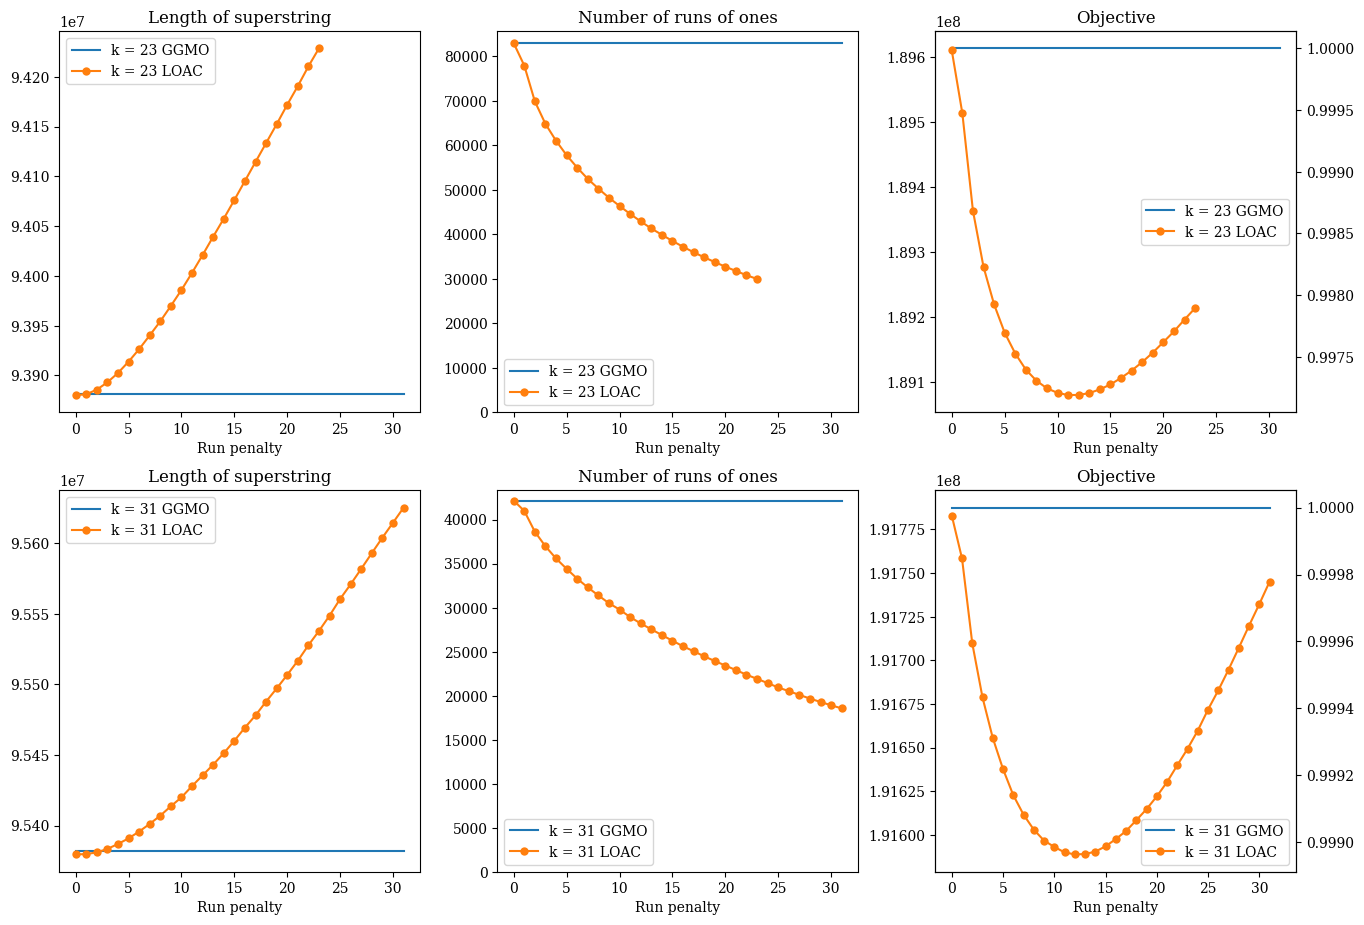

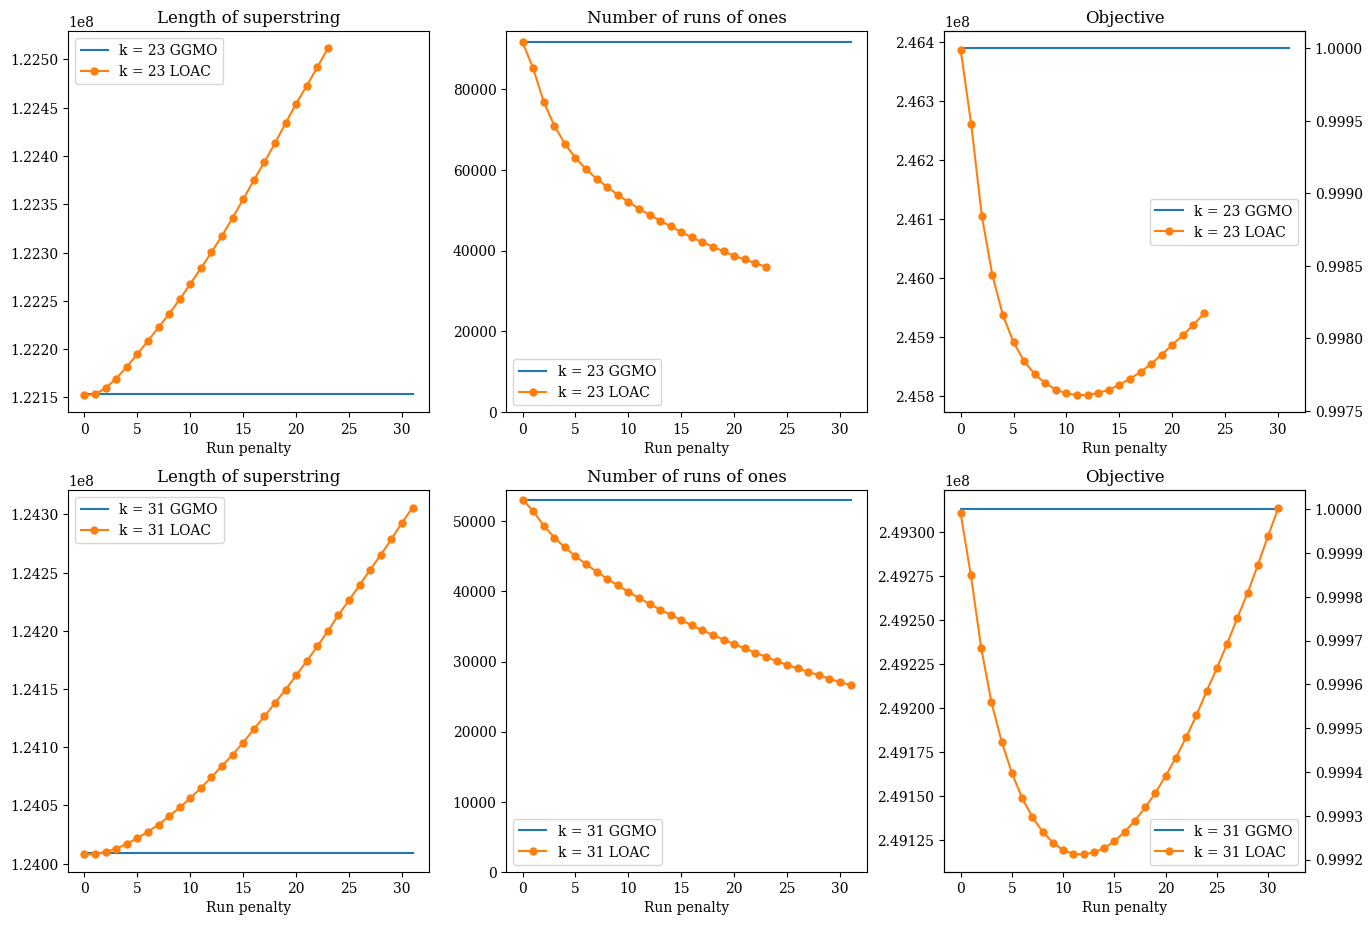

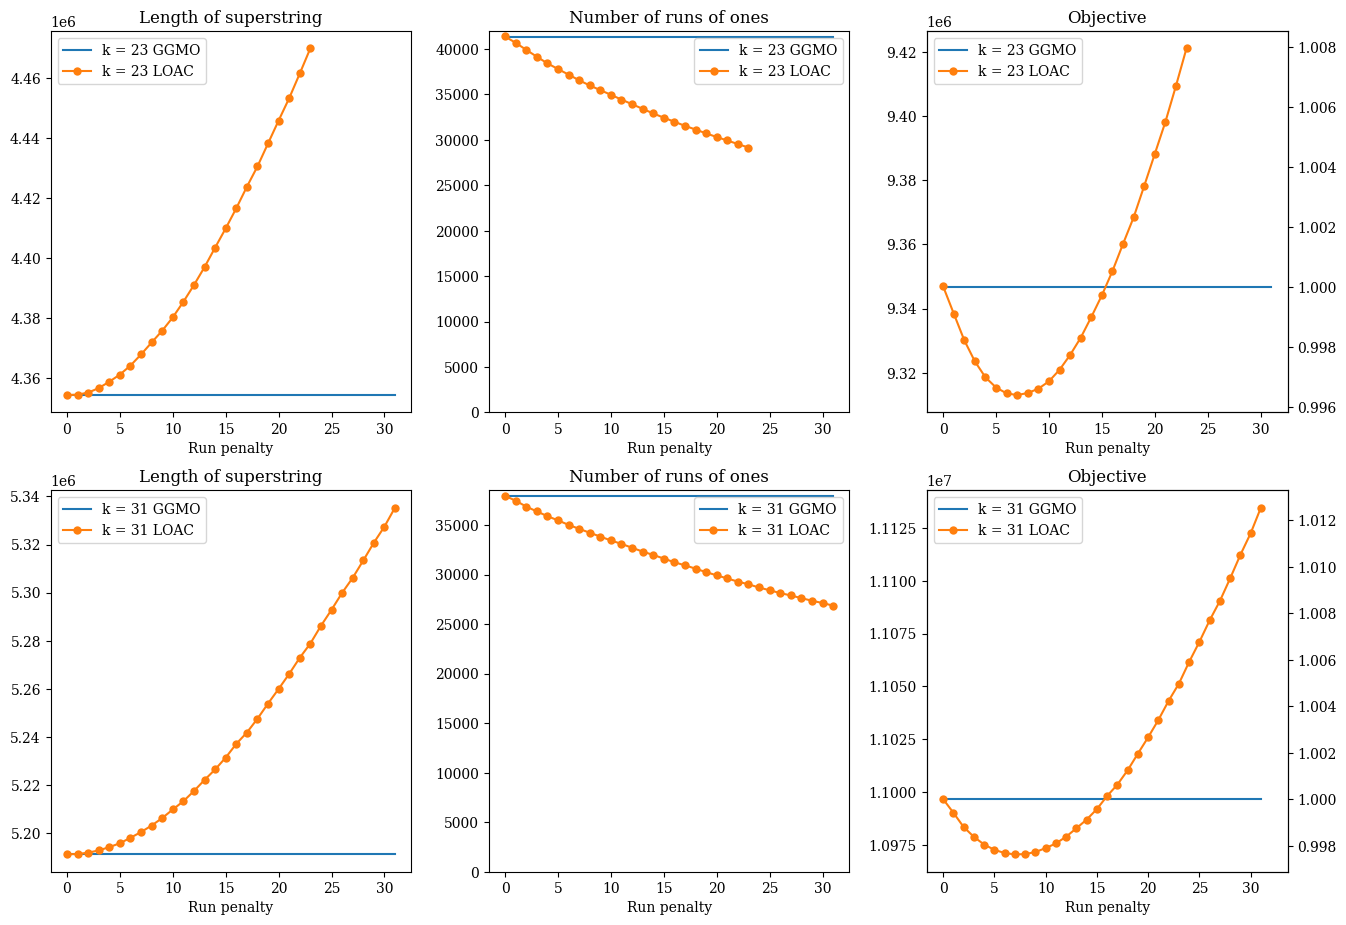

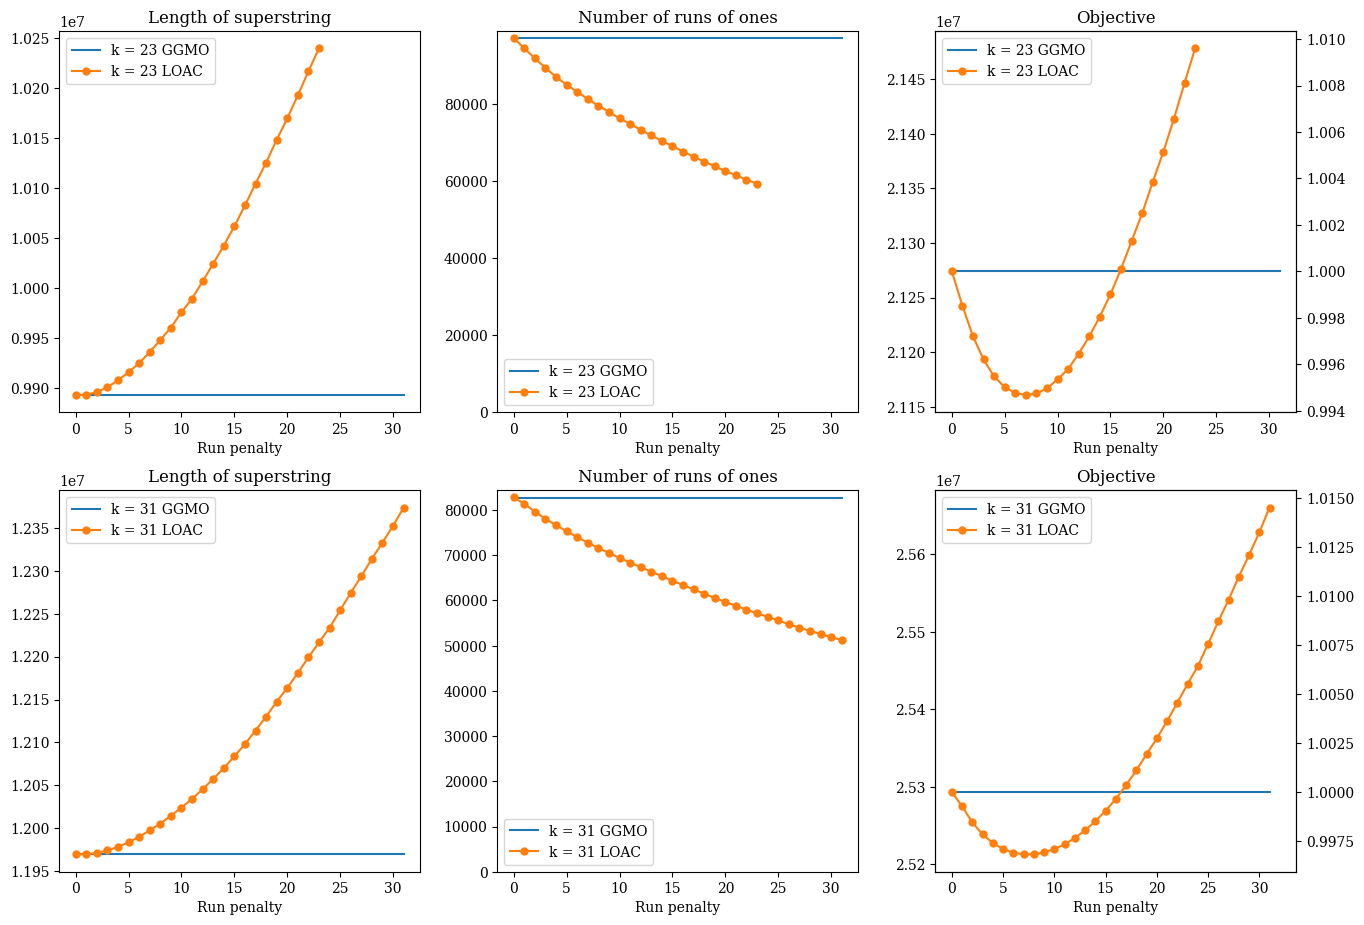

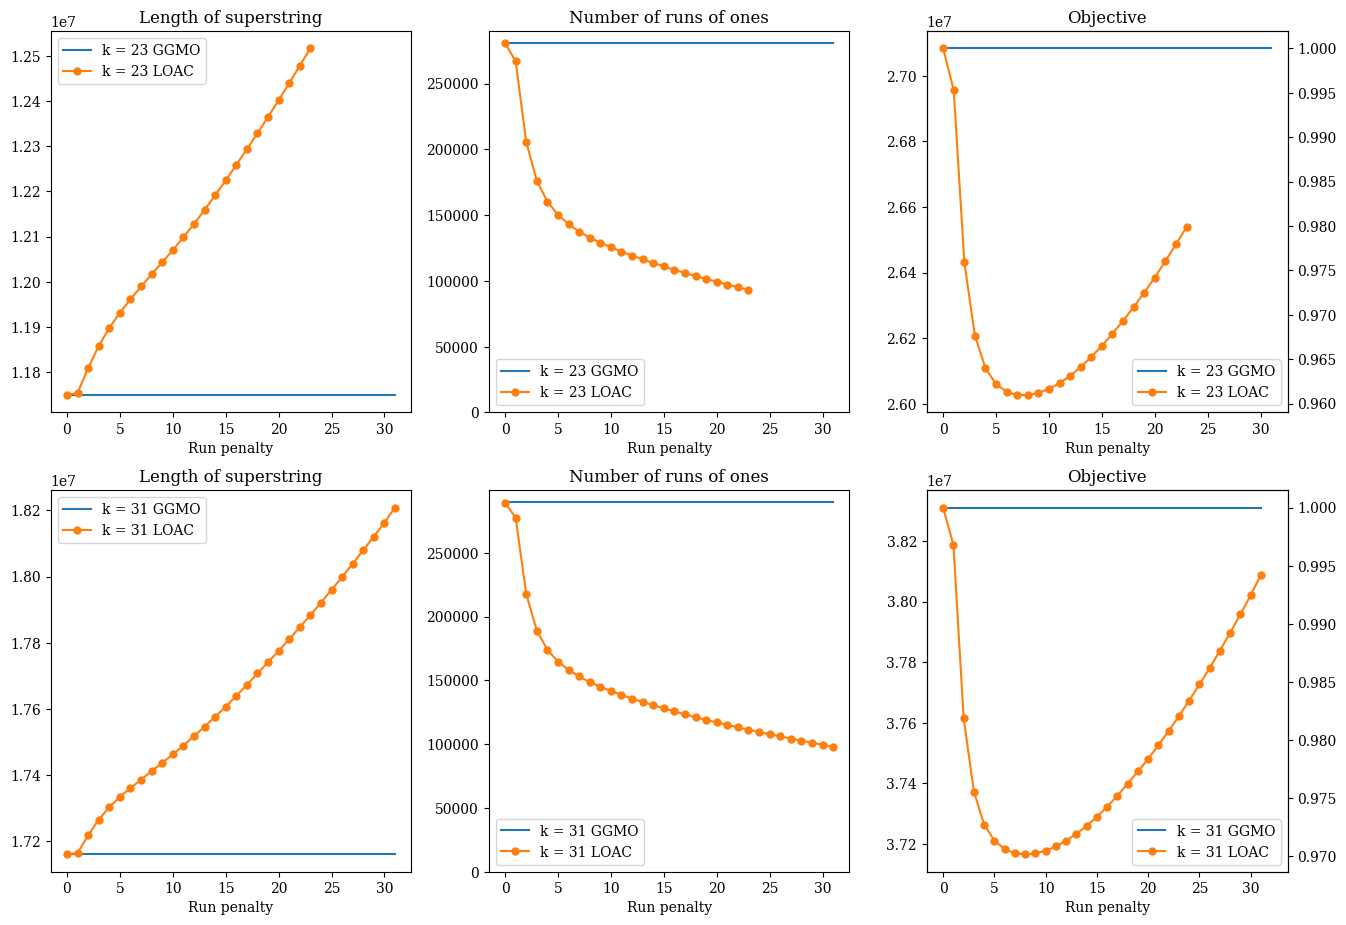

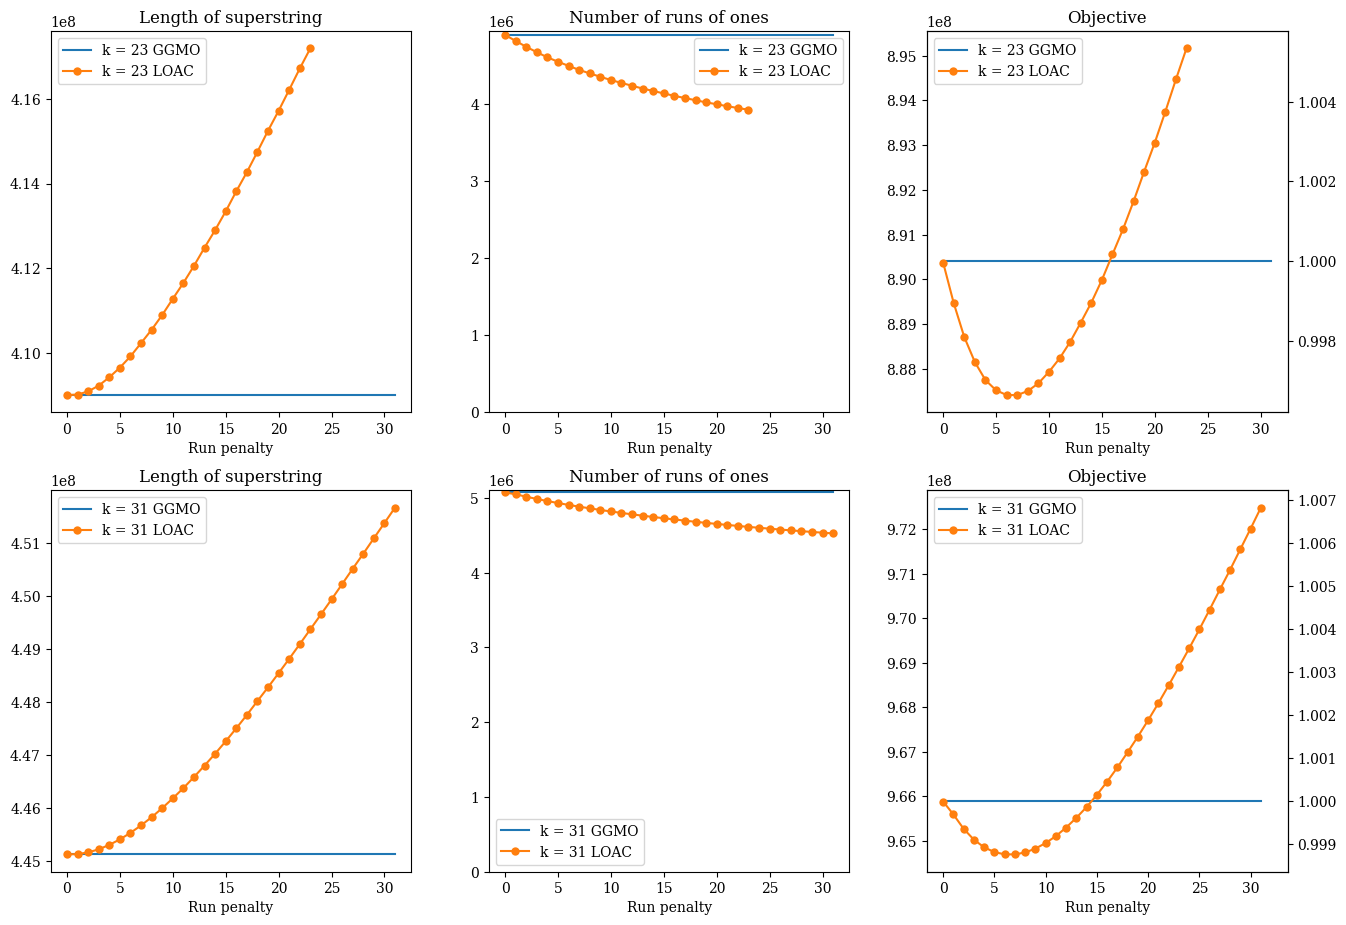

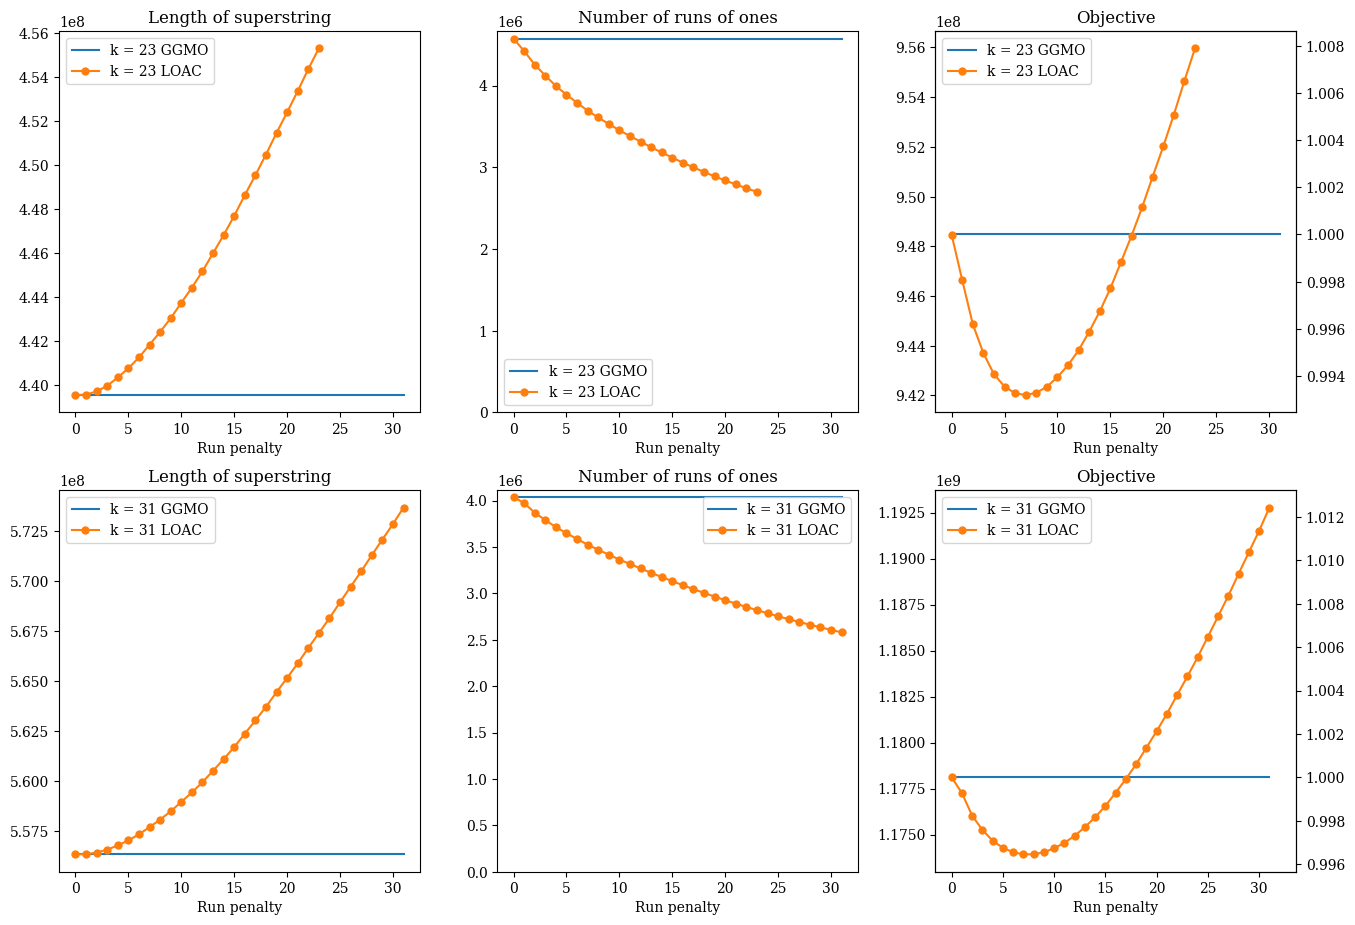

In [53]:
penalty_results = load_all_results("../" + PENALTY_RESULTS_FILE_NAME)
for inp in inputs:
    print_fixed_k_run_penalties(inp, [23, 31], save=True)

In [54]:
def print_fixed_k_run_penalties_overview(k, save=False):
    LABELS_SUBSET = [LABELS[0], LABELS[1], LABELS[4]]
    LABELS_READABLE_SUBSET = [LABELS_READABLE[0], LABELS_READABLE[1], LABELS_READABLE[4]]

    fig, axs = plt.subplots(2, 3)
    fig.set_figheight(9)
    fig.set_figwidth(13.5)
    fig.tight_layout(w_pad=2.5, h_pad=3.5, rect=(0, 0, 0.97, 1))

    for color, inp in enumerate(inputs):
        name = inp[3].replace("(p)", "pangenome").replace("_", " ").strip()
        run_penalty = int(inp[2])
        inp = inp[0]
        if name == "-": continue
        if "subsampled" in inp: continue

        if not (ALGORITHMS[1], inp, k, True, run_penalty) in penalty_results.keys(): continue
        print(name, run_penalty, inp)

        d = penalty_results[(ALGORITHMS[1], inp, k, True, run_penalty)]
        y = run_penalty
        xs = [math.log10(d[LABELS_SUBSET[0]]), math.log10(d[LABELS_SUBSET[1]]), math.log10(d[LABELS_SUBSET[2]]),
              d[LABELS_SUBSET[0]], d[LABELS_SUBSET[1]], d[LABELS_SUBSET[2]]]

        for i, label in enumerate(LABELS_SUBSET + LABELS_SUBSET):
            sns.scatterplot(y=[y], x=xs[i], ax=axs[i // 3, i % 3], label=name)
    
    for i, label in enumerate(LABELS_READABLE_SUBSET + LABELS_READABLE_SUBSET):
        ax = axs[i // 3, i % 3]
        ax.set_title(label + (" (log)" if i < 3 else ""))
    
    if save: fig.savefig(f"../{FIG_DIR}/run-penalty-overview.pdf")


S. cerevisiae 13 scerevisiae.fna
A. thaliana 12 athaliana.fna
C. elegans 12 celegans.fa
D. melanogaster 12 dmelanogaster.fna
N. gonorrheae pangenome 7 ngono_pangenome_RASE_db.unitigs_k128.fa
S. pneumoniae pangenome 7 spneumo_pangenome_RASE_db.unitigs_k128.fa
Sars-cov-2 pangenome 8 sars-cov-2_pangenome_gisaid.unitigs_k128.fa
Human microbiome pangenome 7 human_microbiome_illumina_srs063932.unitigs_minfreq2_k32.fa
E. coli pangenome 7 ecoli_pangenome_661k_HQ.unitigs_k128.fa


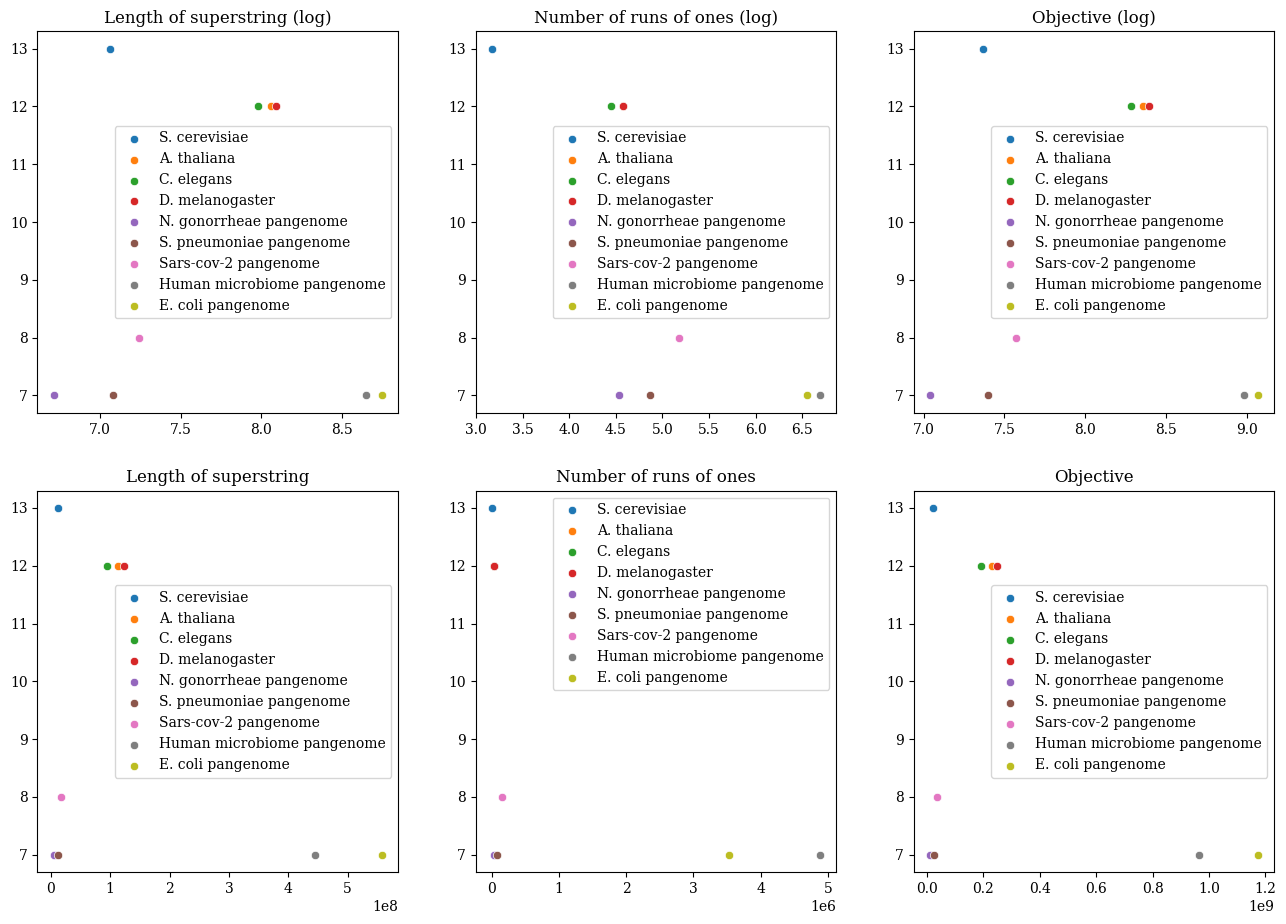

In [55]:
penalty_results = load_all_results("../" + PENALTY_RESULTS_FILE_NAME)
print_fixed_k_run_penalties_overview(31, save=True)

In [56]:
LABELS_SHORT = LABELS[:]
LABELS_SHORT.pop(4)
LABELS_READABLE = ["Length of superstring", "Number of runs of ones", "Time [seconds]", "Memory [kB]", "Relative objective", "Relative compressed size"]

def print_stats_for_input(inp, save=False):
    # print(inp)
    run_penalty = int(inp[2])
    name = inp[3].replace("(p)", "pangenome").replace("_", " ").strip()
    if name == "-": return
    max_ks = list(filter(lambda x: x < int(inp[1]), KS))
    inp = inp[0]
    if "subsampled" in inp: return
    max_xs = []
    empty = True

    fig, axs = plt.subplots(2, 3)
    fig.set_figheight(9)
    fig.set_figwidth(13.5)
    fig.tight_layout(w_pad=2.5, h_pad=3.5)

    sns.lineplot(y=[1 for i in range(len(max_ks))], x=max_ks, ax=axs[-1, -1], marker="o", markeredgewidth=0)
    
    for alg in ALGORITHMS:
        rp = run_penalty if alg != ALG_OLD and alg != ALG_MATCHTIGS else None
        for complements in (True, ):
            ys, xs = [list() for label in LABELS_SHORT], []
            cs = [list() for label in LABELS_COMPRESSIONS]
            for k in KS:
                if not (alg, inp, k, complements, rp) in results.keys(): continue
                empty = False

                d = results[(alg, inp, k, complements, rp)]
                xs.append(k)
                for i in range(len(LABELS_SHORT)):
                    ys[i].append(d[LABELS_SHORT[i]])
                for i in range(len(LABELS_COMPRESSIONS)):
                    cs[i].append(d[LABELS_COMPRESSIONS[i]] / results[(ALG_OLD, inp, k, complements, None)][LABELS_COMPRESSIONS[i]]
                                 if alg != ALG_OLD else 1)

            if len(xs) > len(max_xs): max_xs = xs

            for i, label in enumerate(LABELS_SHORT):
                sns.lineplot(y=ys[i], x=xs, ax=axs[i // 3, i % 3],
                                marker="o" if complements else "s",
                                markeredgewidth=0, label=("GGMO" if alg == ALG_OLD else ("matchtigs" if alg == ALG_MATCHTIGS else "LOAC")))
            if alg != ALG_OLD:
                for i, label in enumerate(LABELS_COMPRESSIONS):
                    sns.lineplot(y=cs[i], x=xs, ax=axs[-1, -1],
                                    marker="o" if complements else "s",
                                    markeredgewidth=0, label=label)
    
    if empty:
        fig.clf()
        return
    
    # fig.suptitle(f"{name}, run penalty: {run_penalty}")
    print(f"{name}, run penalty: {run_penalty}")

    for i, label in enumerate(LABELS_READABLE):
        ax = axs[i // 3, i % 3]
        ax.set_title(label)
        ax.set(xticks=max_xs)
        ax.set_xlabel("k =")
        ax.xaxis.set_label_coords(-0.05, -0.025)
        if i in (1, 2, 3): ax.set_ylim(bottom=0)
    plt.legend()

    if save and not empty: fig.savefig(f"../{FIG_DIR}/{name}.pdf")


S. cerevisiae, run penalty: 13
A. thaliana, run penalty: 12
C. elegans, run penalty: 12
D. melanogaster, run penalty: 12
N. gonorrheae pangenome, run penalty: 7
S. pneumoniae pangenome, run penalty: 7
Sars-cov-2 pangenome, run penalty: 8
Human microbiome pangenome, run penalty: 7
E. coli pangenome, run penalty: 7


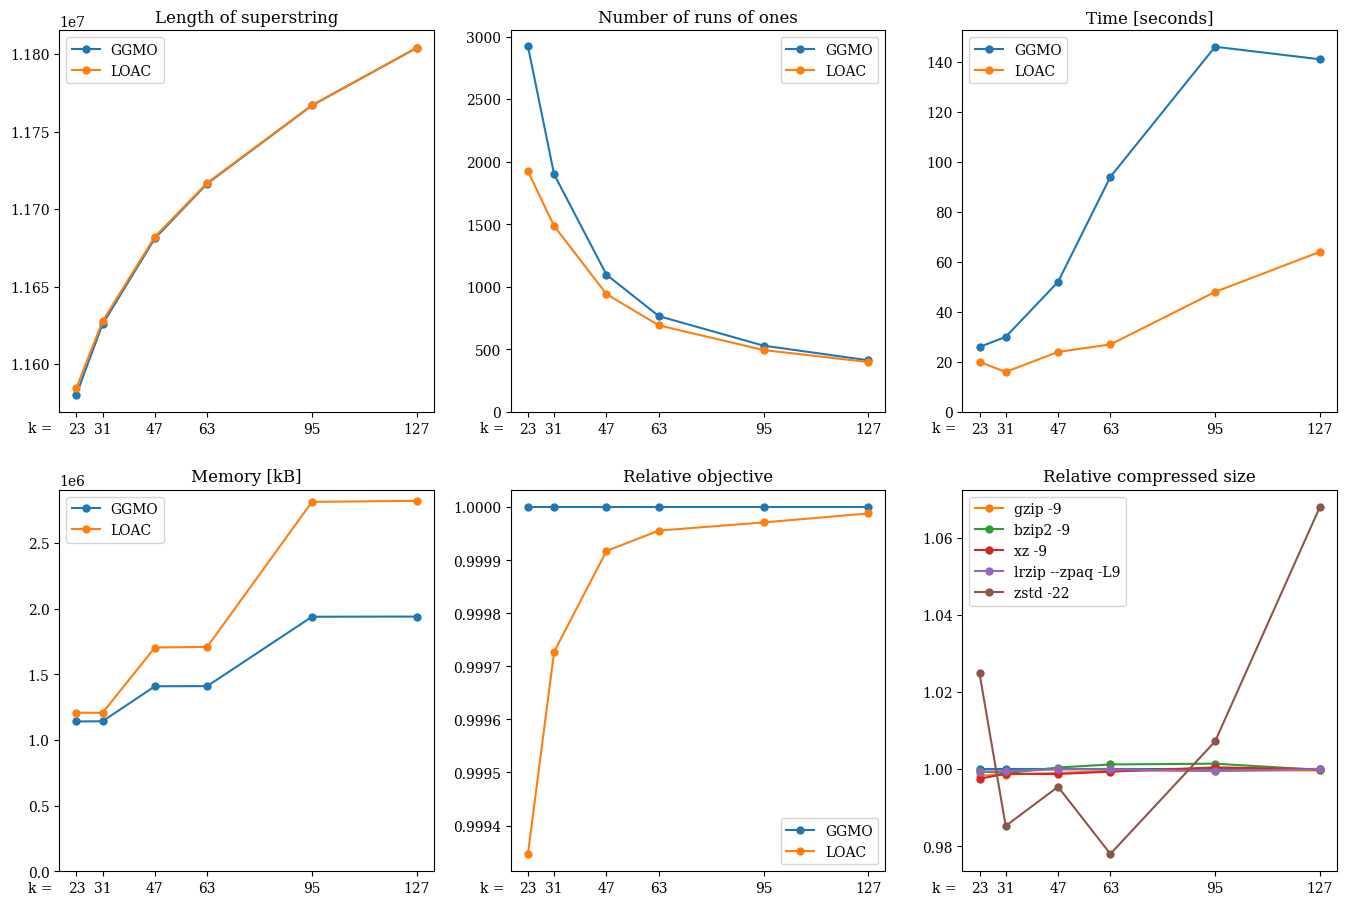

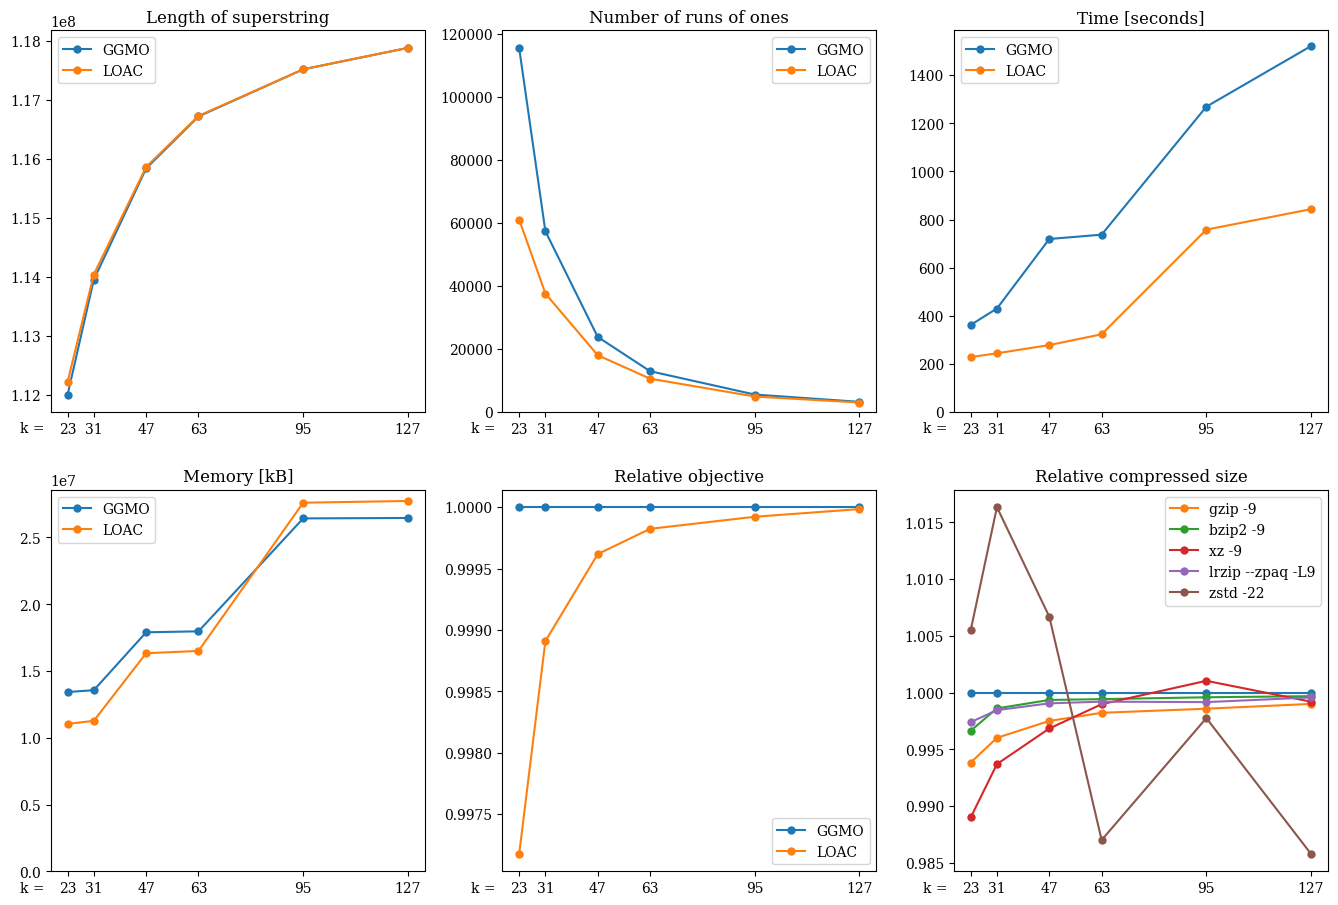

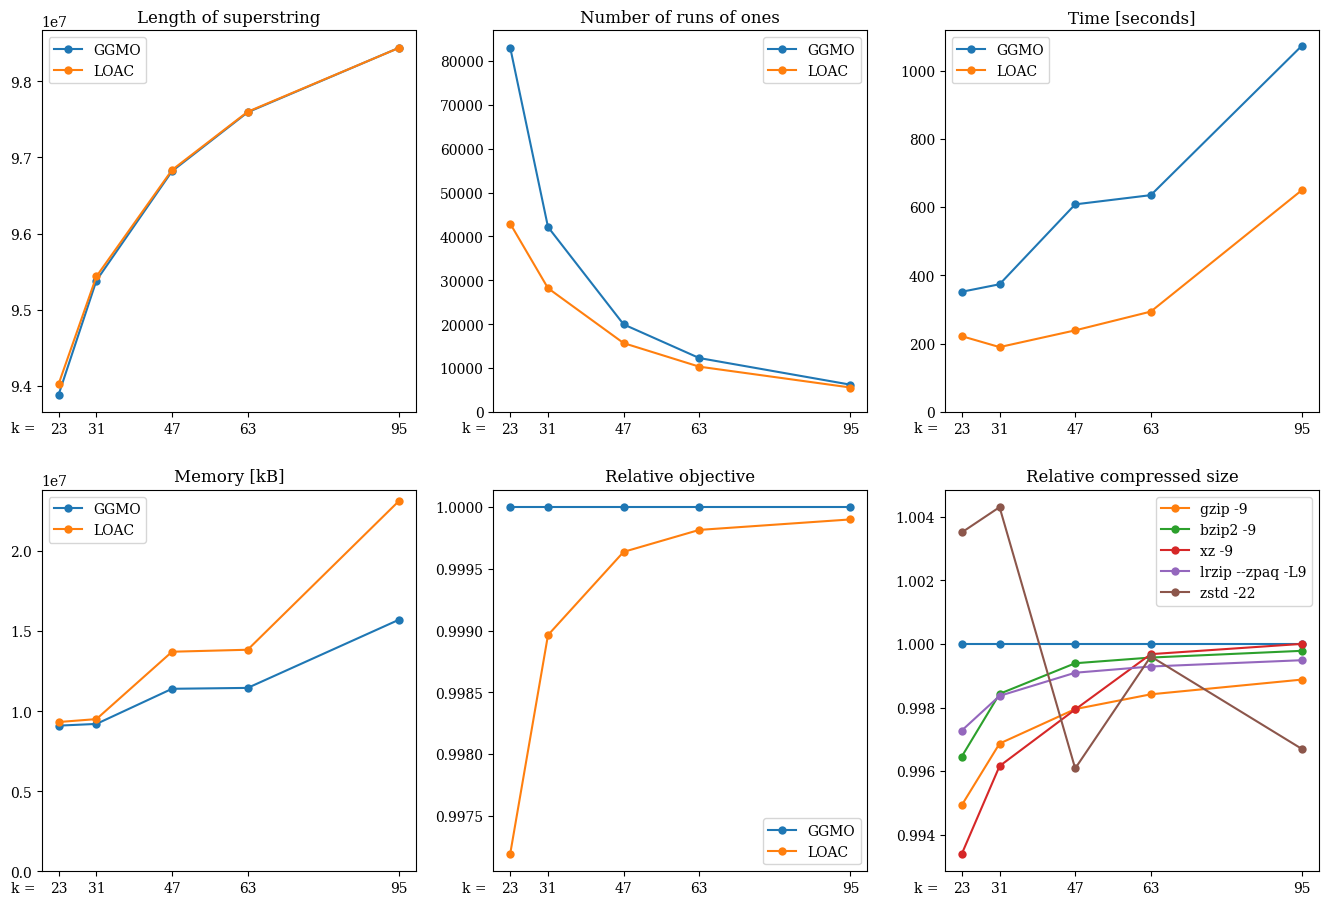

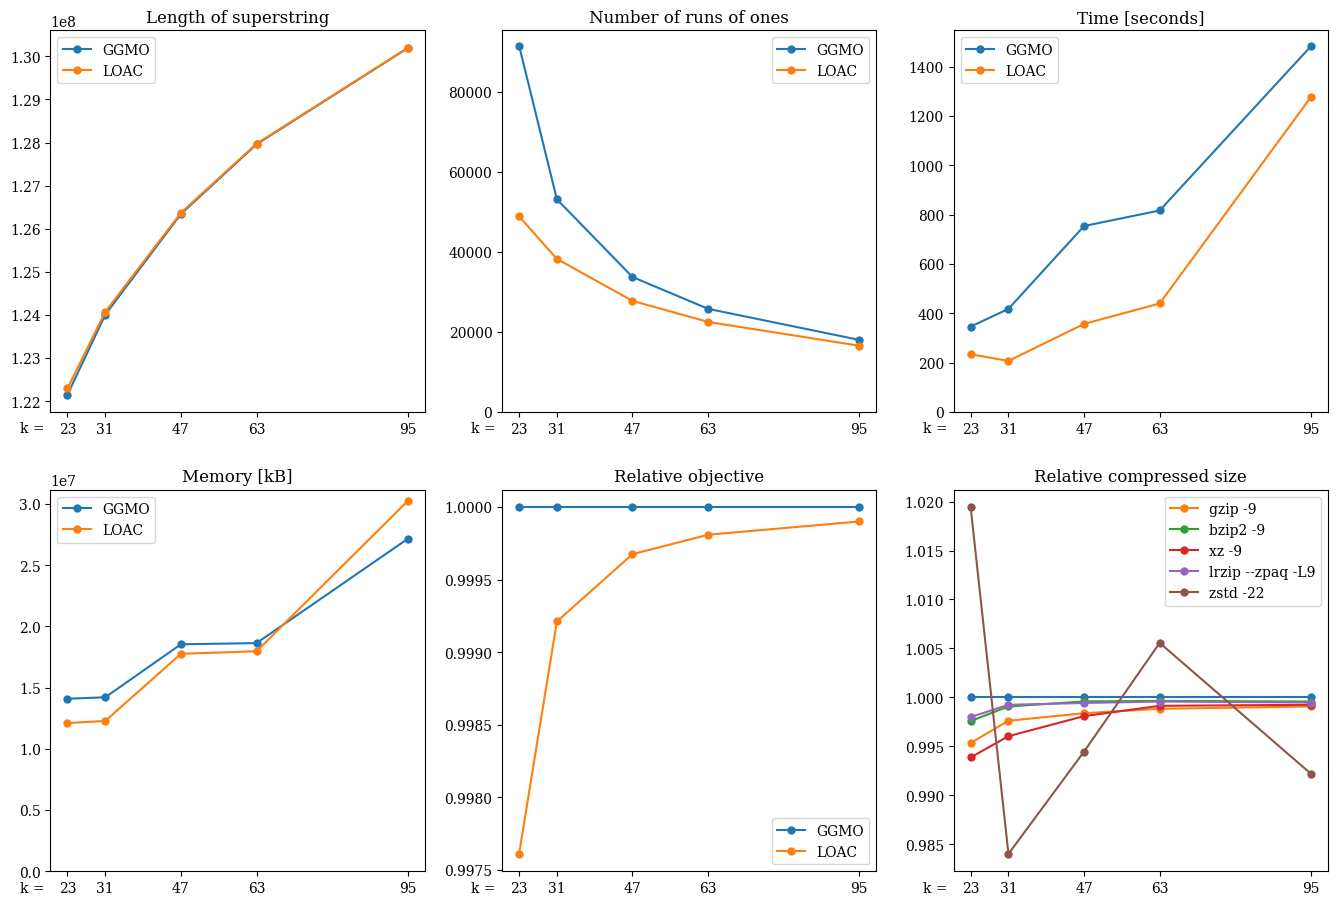

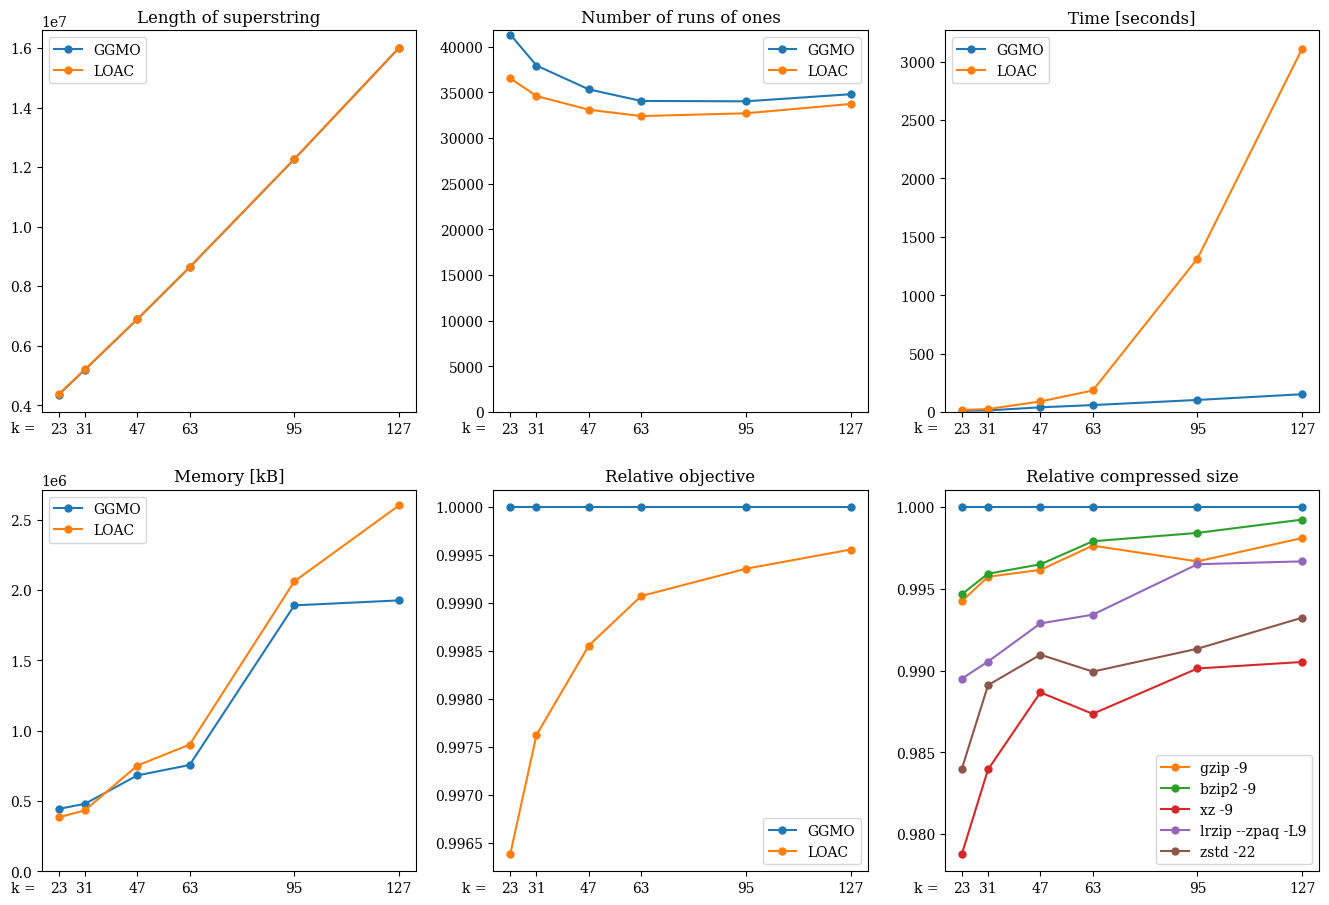

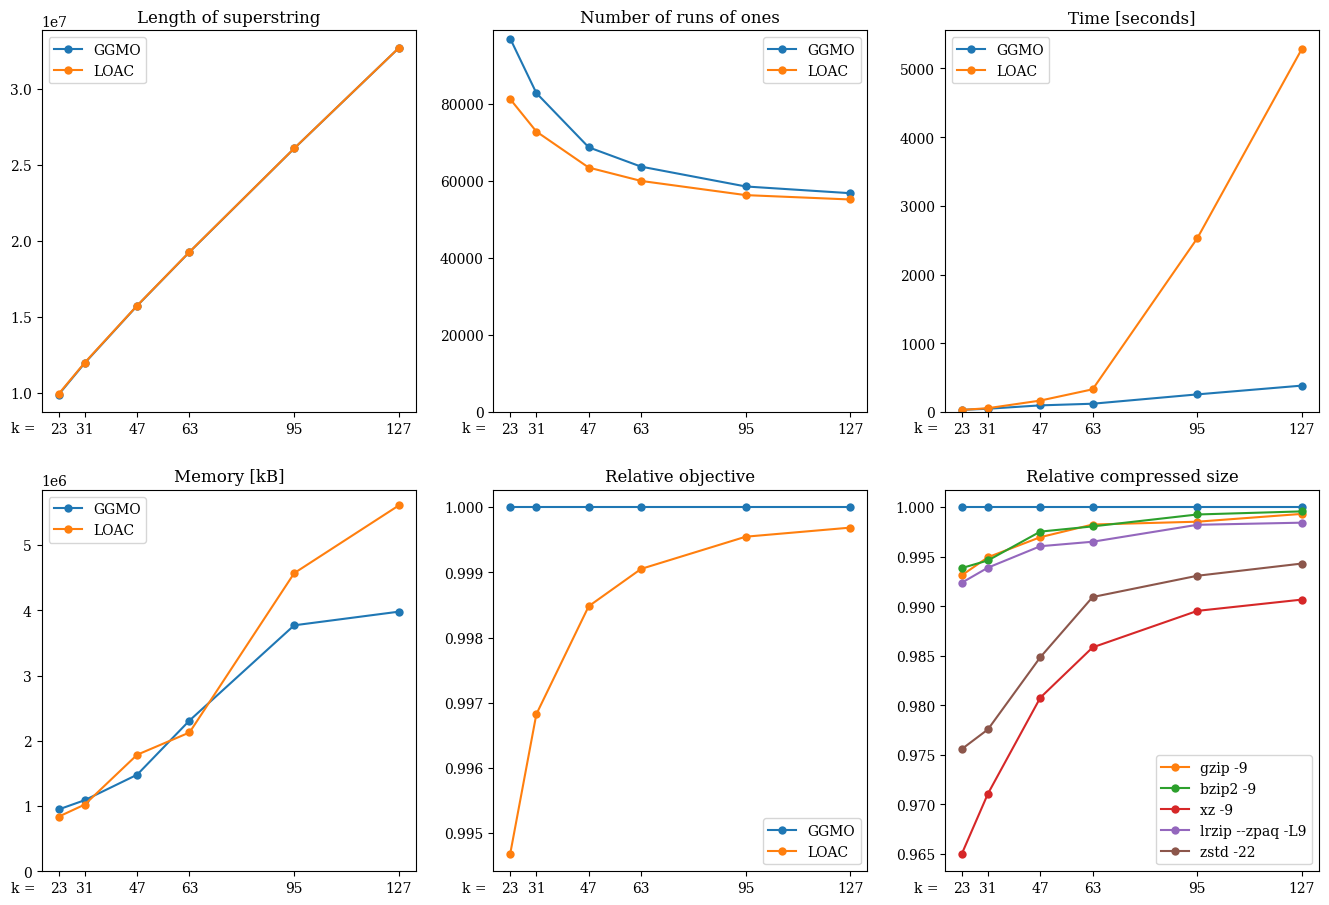

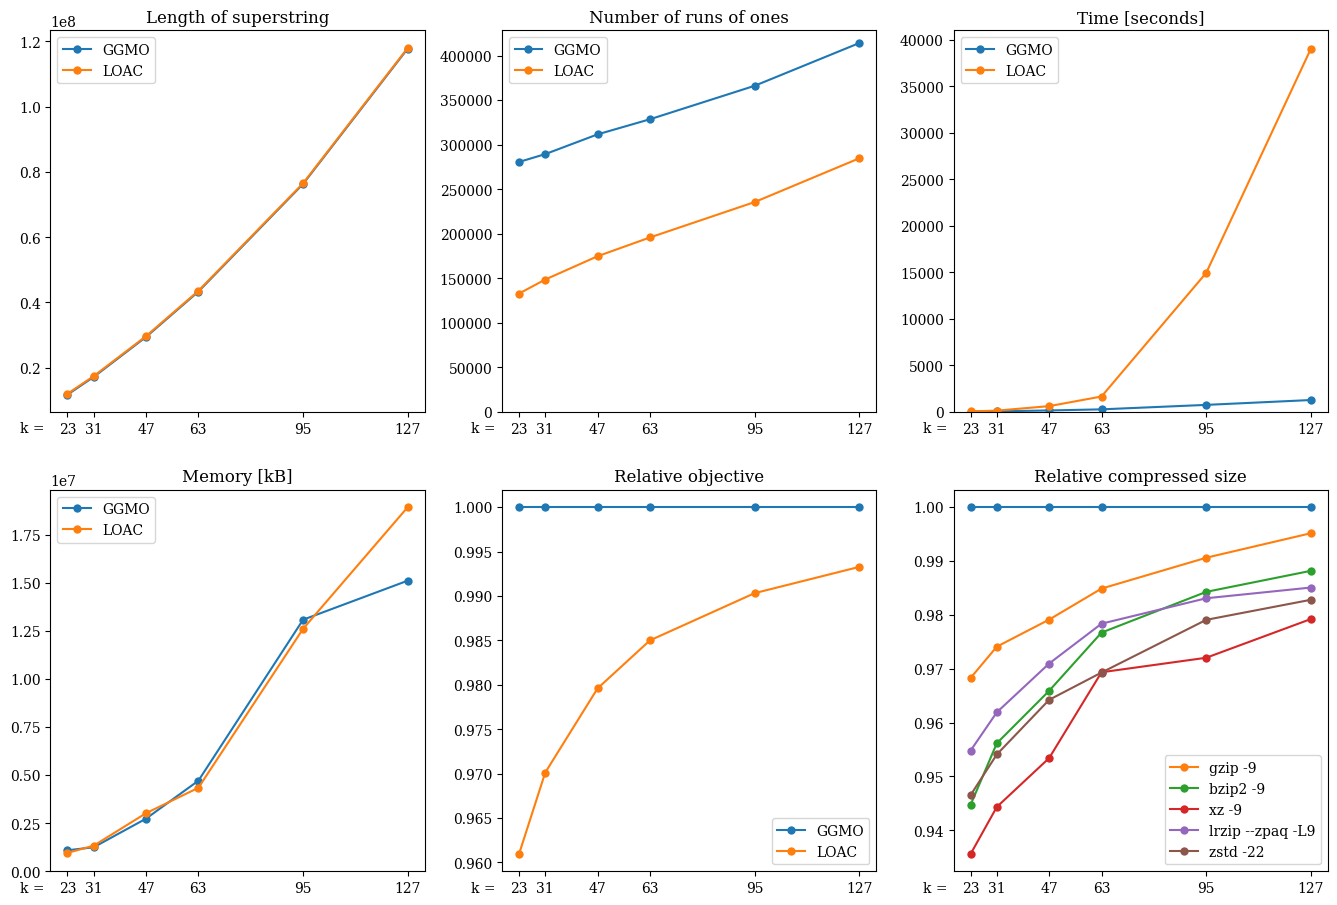

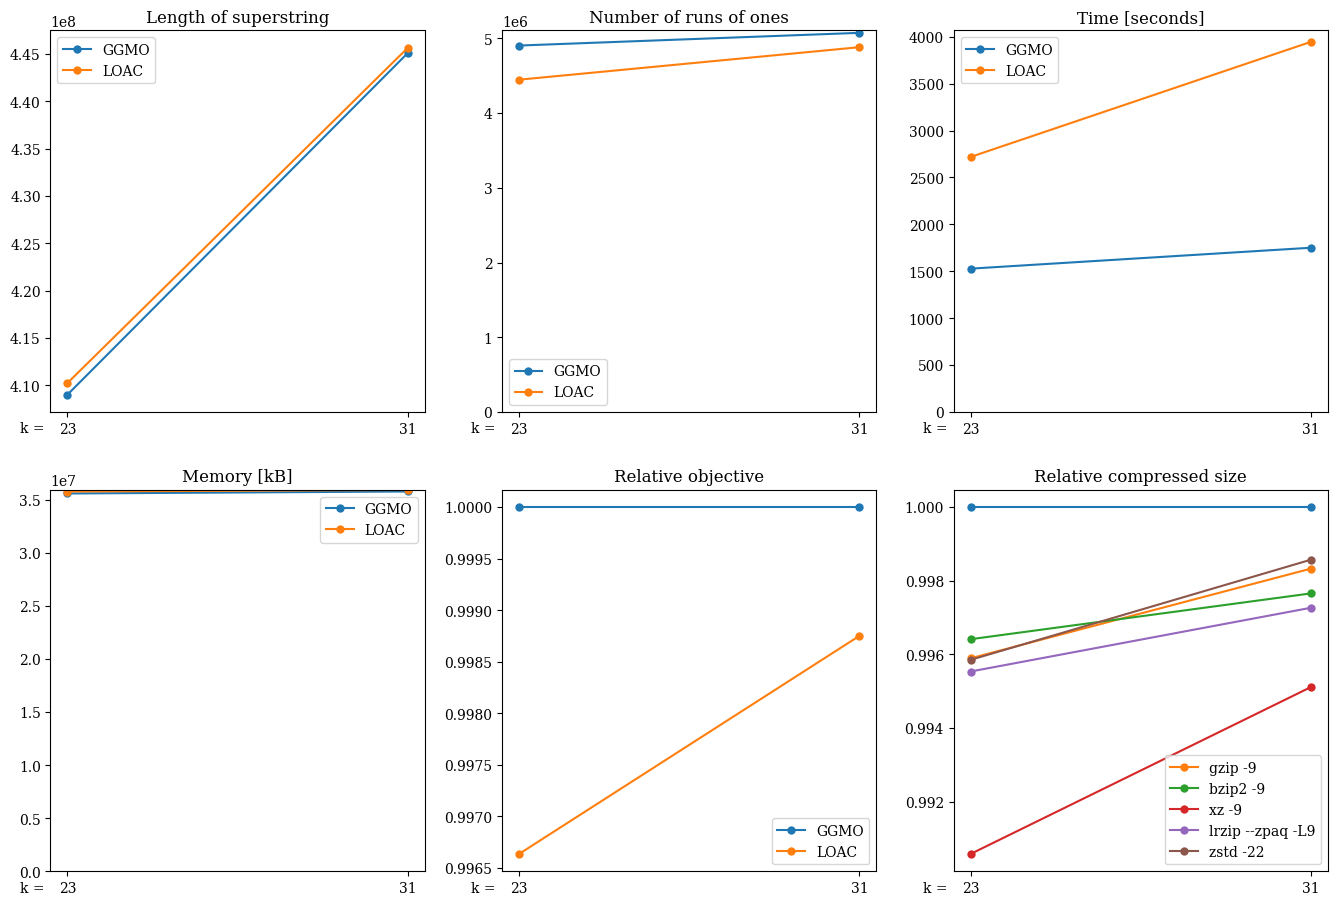

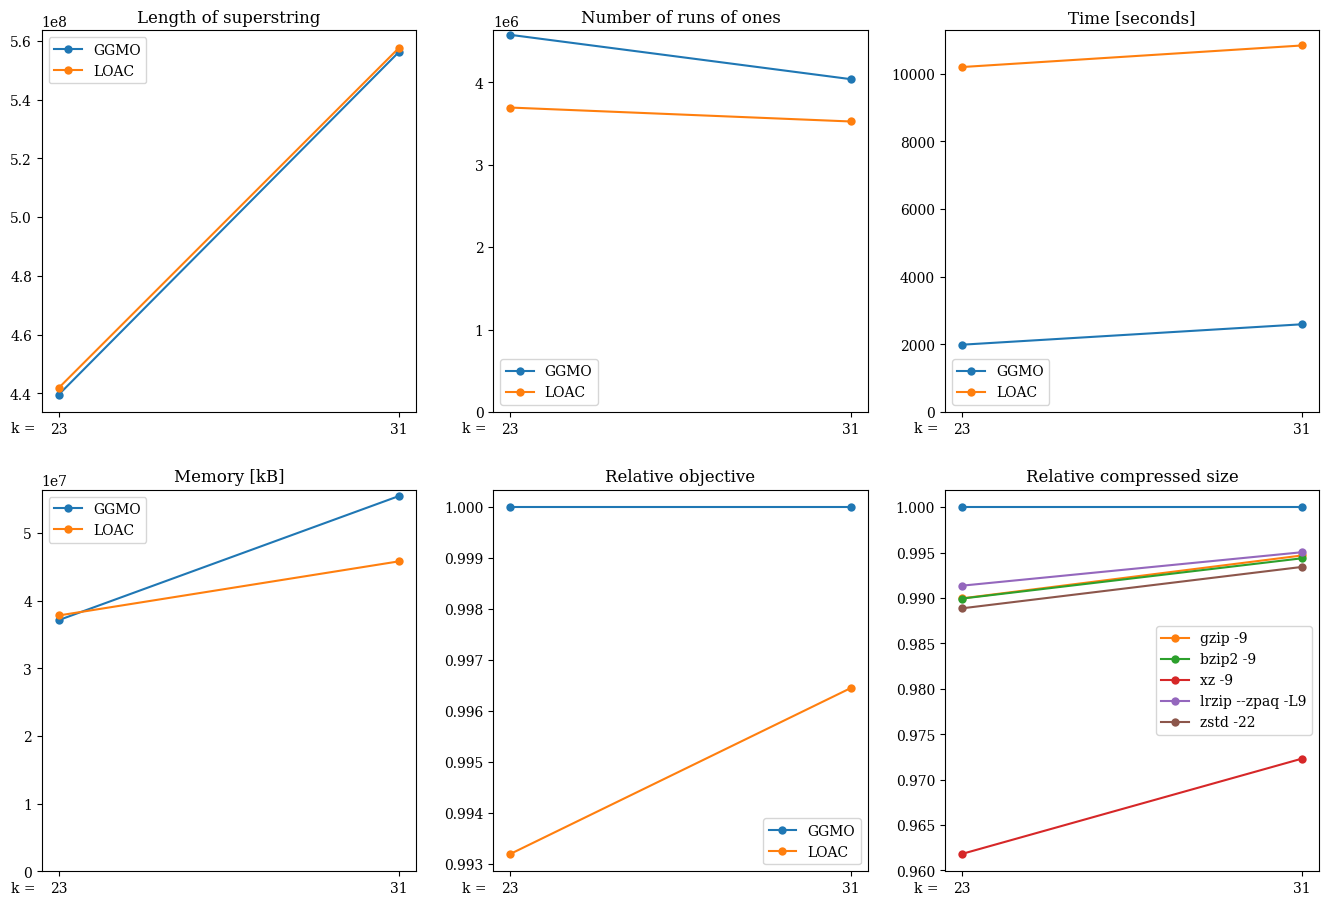

In [57]:
for inp in inputs:
    print_stats_for_input(inp, save=True)